# Data Preparation

The first stage is to download the data from Kaggle and process the images. Because we are building an autoencoder, we will be applying techniques from unsupervised learning. This means we are developing a model which does not have explicit *targets* to learn from. Nevertheless, we can learn useful patterns in the data to perform powerful tasks. In this case we will be learning to denoise images. So first, let's download the images!

In [1]:
import os
import tqdm
import torch
import kagglehub
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Download images and grab base path
path = kagglehub.dataset_download("therealcyberlord/50k-celeba-dataset-64x64")
path = os.path.join(path, '50k')

# List image paths with base path to read in PIL
image_paths = [os.path.join(path, i) for i in os.listdir(path)]

# Check on a path
image_paths[0]

'/home/chris/.cache/kagglehub/datasets/therealcyberlord/50k-celeba-dataset-64x64/versions/1/50k/004770.jpg'

Now the images reside in a cache directory on my machine. Given that there are 50,000 images, Python can only open so many images at a time. Instead we can convert the images to arrays. When stacked we can build a 3D tensor where the *height* and *width* are the image and the *depth* are different images. We also want to convert the images to grayscale to limit computational overhead for this small project.

In [2]:
images = []

# Load, grayscale, and store image arrays
for image_path in tqdm.tqdm(image_paths):
    image = Image.open(image_path)
    image = np.array(image.convert('L'))
    images.append([image])

# Convert to multi-dimensional array
images = np.array(images)
images.shape

100%|███████████████████████████████████| 50000/50000 [00:08<00:00, 6024.23it/s]


(50000, 1, 64, 64)

The image below demonstrates one of the original 64x64 images without noise as the original and simulated noise. As stated above, we will be predicting the original image using the noisy image. The hope is our neural network can learn how to de-noise images well. However, we will develop some functions to add noise to the tensors during the PyTorch training procedure. This is because adding random noise each time an image is loaded creates infinite training examples as opposed to creating only one noisy copy per image.

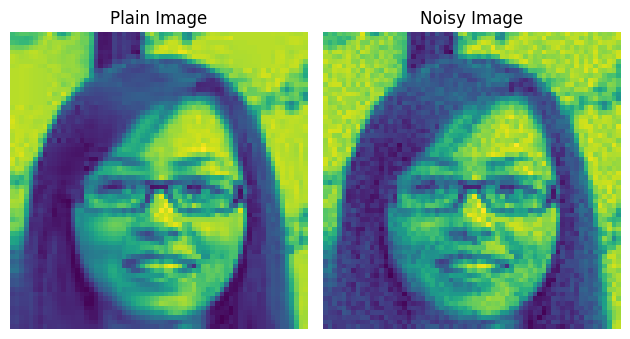

In [3]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2)
test_image = images[0][0]

# Show plain image (the targets)
axes[0].imshow(test_image)
axes[0].set_title('Plain Image')
axes[0].axis('off')  

# Show noisy image (the inputs)
noise = np.random.random(test_image.shape)
axes[1].imshow(test_image + noise * 25.0)
axes[1].set_title('Noisy Image')
axes[1].axis('off')

# Show images
plt.tight_layout()
plt.show()

Finally, we want to serialize our tensors to disk. This allows us to leverage them in future steps in a fast, binary format. As said above, we are saving the plain images without noise and will use the RNG in `torch` to create infinite training examples. 

In [4]:
torch.save(torch.tensor(images, dtype=torch.float32), '../data/images.pt')